In [1]:
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.integrate import odeint
from utils import reshape_dataset_to_torch, train_L63_EGA_Ensemble, Lorenz_63

In [2]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# parameters of the training experiment
params = {'grad_mode': 'EGA-Ensemble','dim_state': 3, 'dim_output': 3, 'transition_layers': 2, 'dim_hidden_dyn_mdl': 3, 'train_size': 5000,
          'ntrain': 300, 'dt_integration': 0.01, 'pretrained': False, 'Batch_size': 128, 'seq_size': 10,
          'nb_part': 5, 'output_folder': 'output_models/',
          'model_save_file_name': 'L63_EGA-Ensemble.pt', 'device': 'cpu'}

In [4]:
class closure_term(torch.nn.Module):
    def __init__(self, params):
        super(closure_term, self).__init__()
        self.trans_layers = params['transition_layers']
        self.transLayers  = torch.nn.ModuleList([torch.nn.Linear(params['dim_state'], params['dim_hidden_dyn_mdl'])])
        self.transLayers.extend([torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_hidden_dyn_mdl']) for i in range(1, params['transition_layers'])])
        self.out_transLayers = torch.nn.Linear(params['dim_hidden_dyn_mdl'],params['dim_state']) 
    def forward(self, inp):
        aug_vect = inp#torch.cat((L_outp, BP_outp), dim=1)
        #print(aug_vect)
        for i in range((self.trans_layers)):
            aug_vect = torch.tanh(self.transLayers[i](aug_vect))
        aug_vect = self.out_transLayers(aug_vect)
        grad = aug_vect#self.outputLayer(aug_vect)
        return grad 
M_theta = closure_term(params)

In [5]:
class GD:
    model = 'Lorenz_63'

    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0 / 3

    dt_integration = params['dt_integration']  # integration time
    nb_loop_data = 60.0

In [6]:
# run the data generation
dataset = generate_data(GD)

In [7]:
# reshaping dataset
X_train, Y_train, X_test, Y_test = reshape_dataset_to_torch(dataset, params['seq_size'], params['train_size'])
training_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=params['Batch_size'], shuffle=True,
                                         pin_memory=False),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=params['Batch_size'], shuffle=False, pin_memory=False),
}

In [8]:
optimizer_ft     = torch.optim.Adam(M_theta.parameters(), lr=0.1)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)
model_best_valid, model, loss_train, loss_val = train_L63_EGA_Ensemble(M_theta, dataloaders, optimizer_ft, exp_lr_scheduler, device = params['device'], num_epochs=300,  dt = params['dt_integration'], seq_size = params['seq_size'], nb_part = params['nb_part'], parameters = GD.parameters)
torch.save(model.state_dict(), params['output_folder']+params['model_save_file_name'])

Epoch 0/299
----------


C:\Users\Administrateur\PycharmProjects\EGA\pythonProject\L63\utils.py:178: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func, theta = make_functional(model)
C:\Users\Administrateur\PycharmProjects\EGA\pythonProject\L63\utils.py:179: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  jac_theta_dict = vm

train: loss: 0.322760
LR 0.1
val: loss: 0.243672
saving best model
17m 56s
Epoch 1/299
----------
train: loss: 0.192337
LR 0.1
val: loss: 0.143628
saving best model
18m 30s
Epoch 2/299
----------
train: loss: 0.113921
LR 0.1
val: loss: 0.090061
saving best model
22m 22s
Epoch 3/299
----------
train: loss: 0.076886
LR 0.1
val: loss: 0.065265
saving best model
22m 2s
Epoch 4/299
----------
train: loss: 0.058190
LR 0.1
val: loss: 0.055188
saving best model
18m 23s
Epoch 5/299
----------
train: loss: 0.046933
LR 0.1
val: loss: 0.037997
saving best model
21m 0s
Epoch 6/299
----------
train: loss: 0.032729
LR 0.1
val: loss: 0.027380
saving best model
25m 33s
Epoch 7/299
----------
train: loss: 0.023995
LR 0.1
val: loss: 0.020397
saving best model
19m 10s
Epoch 8/299
----------
train: loss: 0.018146
LR 0.1
val: loss: 0.017810
saving best model
19m 6s
Epoch 9/299
----------
train: loss: 0.015086
LR 0.1
val: loss: 0.012723
saving best model
18m 59s
Epoch 10/299
----------
train: loss: 0.011827


In [9]:
initial_condition_test = next(iter(dataloaders['val']))[0][0,:]
simulation_hybrid = odeint(Lorenz_63,initial_condition_test,np.arange(0,40+0.000001,GD.dt_integration),args=(model_best_valid,GD.parameters))
simulation_init_sys  = odeint(Lorenz_63,initial_condition_test,np.arange(0,40+0.000001,GD.dt_integration),args=(model_best_valid,GD.parameters, False))

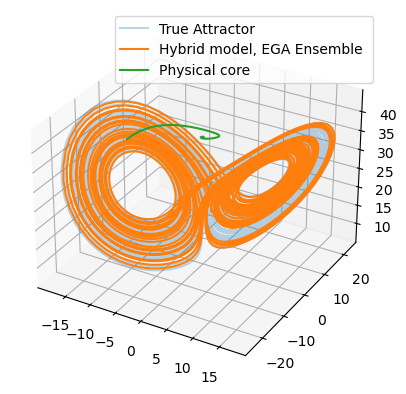

In [10]:
# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the line in 3D
ax.plot(dataset[:,0], dataset[:,1], dataset[:,2], label='True Attractor', alpha = 0.3)
ax.plot(simulation_hybrid[:,0], simulation_hybrid[:,1], simulation_hybrid[:,2], label='Hybrid model, EGA Ensemble ')
ax.plot(simulation_init_sys[:,0], simulation_init_sys[:,1], simulation_init_sys[:,2], label='Physical core')
plt.legend()